In [2]:
%pip install snowflake-connector-python==2.3.5

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, './scripts')
from snowflakeDbConnector import SnowflakeDbConnector

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/snowflake/connector/options.py:78: UserWarning: You have an incompatible version of 'pyarrow' installed (6.0.1), please install a version that adheres to: 'pyarrow<0.18.0,>=0.17.0; extra == "pandas"'
  warn_incompatible_dep('pyarrow', _installed_pyarrow_version.version, _expected_pyarrow_version)


In [4]:
client = 'colgate'
snowflake_db_connector = SnowflakeDbConnector()
database_query = f'''
        use database brands_{client};
        '''
snowflake_db_connector.getResultForQuery(database_query)

,status
0,Statement executed successfully.


In [41]:
dataframe_query = f'''
        select a.CAMPAIGN_ID,a.IMPRESSIONS,a.CLICKS,a.MATCH_TYPE,a.KEYWORDBID,
        case a.MATCH_TYPE
        when 'BROAD' then 1
        when 'PHRASE' then 0.72
        when 'EXACT' then 0.87 end,
        b.CAMPAIGN_ID,b.CLICKS,b.IMPRESSIONS
        from ams.keywords_headline_report a
        join ams.campaigns_headline_report b on a.CAMPAIGN_ID=b.CAMPAIGN_ID
        where a.KEYWORDSTATUS='Enabled'
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,CAMPAIGN_ID,IMPRESSIONS,CLICKS,MATCH_TYPE,KEYWORDBID,CASE A.MATCH_TYPE\n WHEN 'BROAD' THEN 1\n WHEN 'PHRASE' THEN 0.72\n WHEN 'EXACT' THEN 0.87 END,CAMPAIGN_ID,CLICKS,IMPRESSIONS
0,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
1,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
2,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
3,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
4,144221050922434038,0,0,PHRASE,2.6100000000,0.72,144221050922434038,0,0
...,...,...,...,...,...,...,...,...,...
995,144382302370524869,0,0,EXACT,1.1399900000,0.87,144382302370524869,0,0
996,144382302370524869,0,0,EXACT,1.1399900000,0.87,144382302370524869,0,0
997,144382302370524869,0,0,EXACT,1.1399900000,0.87,144382302370524869,0,0
998,144382302370524869,0,0,EXACT,1.1399900000,0.87,144382302370524869,0,0


In [24]:
# for getting numbers per match_type

dataframe_query = f'''
        select a.MATCH_TYPE,sum(a.CLICKS),sum(a.KEYWORDBID),sum(a.IMPRESSIONS)
        from ams.keywords_headline_report a
        where a.KEYWORDSTATUS='Enabled'
        and a.PROFILE_ID=1414667831379156
        group by a.MATCH_TYPE
        limit 1000 ;
        '''
        
    
# #  scaling down the values to 0-1
# dataframe_query = f'''
#         select a, c/max(c), d/max(d), e/max(e) 
#         from
#         (
#         select a.MATCH_TYPE as a,sum(a.CLICKS) as c,sum(a.KEYWORDBID) as d,sum(a.IMPRESSIONS) as e
#         from ams.keywords_headline_report a
#         where a.KEYWORDSTATUS='Enabled'
#         and a.PROFILE_ID=1414667831379156
#         group by a.MATCH_TYPE
#         ) as src
#         group by a;
#         '''
    
    
        
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,MATCH_TYPE,SUM(A.CLICKS),SUM(A.KEYWORDBID),SUM(A.IMPRESSIONS)
0,PHRASE,131978,21189261.2003500000,49228499
1,EXACT,112526,26004683.0981900000,27514910
2,BROAD,29849,9801353.7618300000,7705583


In [42]:
# for getting numbers per match_type

dataframe_query = f'''
        select 
        a.MATCH_TYPE,sum(a.CLICKS)/count(*),sum(a.KEYWORDBID)/count(*),sum(a.IMPRESSIONS)/count(*),count(*)
        from ams.keywords_headline_report a
        where a.KEYWORDSTATUS='Enabled'
        and a.PROFILE_ID=1414667831379156
        group by a.MATCH_TYPE
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)
keywords_report_df2

,MATCH_TYPE,SUM(A.CLICKS)/COUNT(*),SUM(A.KEYWORDBID)/COUNT(*),SUM(A.IMPRESSIONS)/COUNT(*),COUNT(*)
0,BROAD,0.005180,1.700789467152,1.337119,5762826
1,EXACT,0.012772,2.951713342428,3.123135,8810030
2,PHRASE,0.012137,1.948565207376,4.527055,10874289


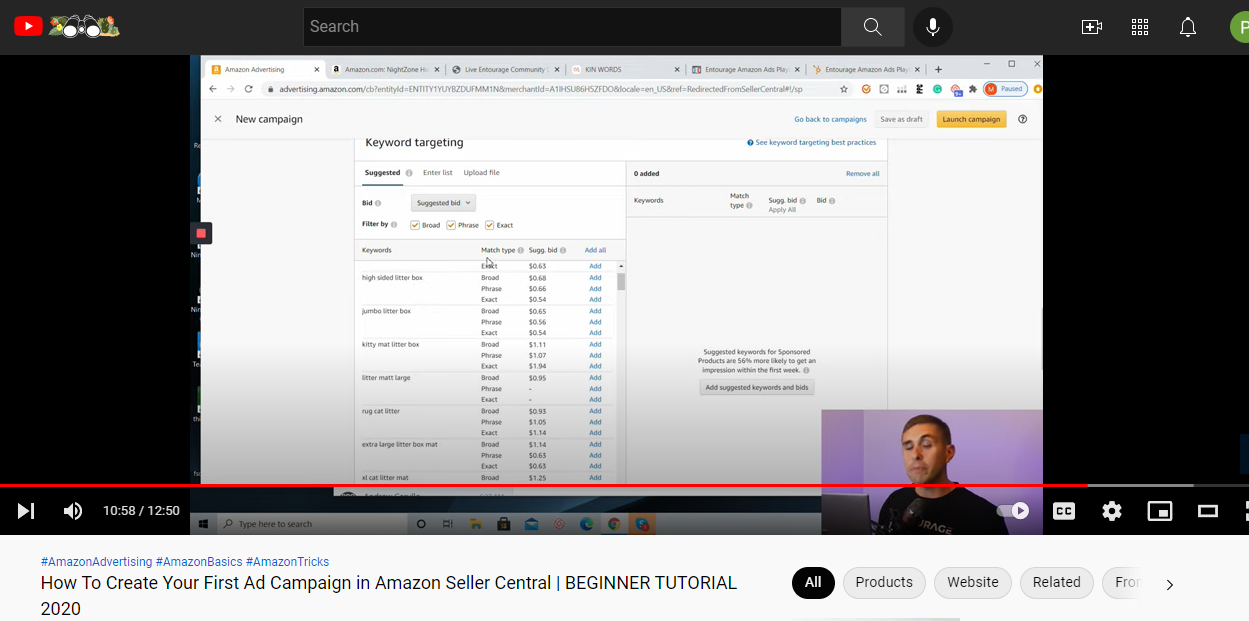


In [ ]:
# Aim for getting Search_rank for (campaign,keyword-text-,bid)table2 by (search- in table5)
# for getting numbers per match_type

# ATTENTION::: a.KEYWORDSTATUS='Enabled'; bcoz we considering only live keywords whose entry reflects real-world market effects, 
#     wherein for stopped, paused ones, they will give 0 clicks, impressions but significant bid-values..... 
#      this will deviate our analysis (outlier, not valid data)

dataframe_query = f'''
        select a.MATCH_TYPE,a.CLICKS,a.KEYWORDBID,a.IMPRESSIONS, a.KEYWORD_TEXT,
        b.SEARCH_RANK, b.SEARCH
        from ams.keywords_headline_report a
        join aramus.search_data_archive b on lower(a.KEYWORD_TEXT)=lower(b.SEARCH)
        where a.KEYWORDSTATUS='Enabled'
        and a.PROFILE_ID=1414667831379156
        order by b.SEARCH_RANK desc
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,MATCH_TYPE,CLICKS,KEYWORDBID,IMPRESSIONS,KEYWORD_TEXT,SEARCH_RANK,SEARCH
0,PHRASE,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
1,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
2,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
3,PHRASE,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
4,PHRASE,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
...,...,...,...,...,...,...,...
995,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
996,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
997,PHRASE,0,0.4500000000,0,infant toothbrush,72,infant toothbrush
998,EXACT,0,0.4500000000,0,infant toothbrush,72,infant toothbrush


In [7]:
dataframe_query = f'''
        select distinct CAMPAIGN_ID,PROFILE_ID,CLIENT_ID
        from ams.keywords_headline_report a
        where 
        a.PROFILE_ID=1414667831379156
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,CAMPAIGN_ID,PROFILE_ID,CLIENT_ID
0,144375940572279517,1414667831379156,850
1,144176604151811220,1414667831379156,850
2,144362662416931805,1414667831379156,850
3,144119334879325302,1414667831379156,850
4,144218402871724521,1414667831379156,850
...,...,...,...
281,144292961280578087,1414667831379156,850
282,144295556514442213,1414667831379156,850
283,144348535967819632,1414667831379156,850
284,144257570019182639,1414667831379156,850


In [47]:
dataframe_query = f'''
        select distinct KEYWORD_ID,KEYWORD_TEXT,count(*)
        from ams.keywords_headline_report a
        group by keyword_id,KEYWORD_TEXT
        having count(*)<>1
        order by keyword_id,KEYWORD_TEXT
        limit 1000 ;
        '''
keywords_report_df2 = snowflake_db_connector.getResultForQuery(dataframe_query)

keywords_report_df2

,KEYWORD_ID,KEYWORD_TEXT,COUNT(*)
0,144115197796488870,+natural +bar +soap +with +shea +butter,639
1,144115197943006137,toothpaste for kids,298
2,144115198522960783,toms spearmint toothpaste,382
3,144115201522837997,colgate teeth whitening,298
4,144115205424336262,toms of maine bar soap for men,649
...,...,...,...
995,144119004372539516,teen spirit,649
996,144119004425848576,toms brand deodorant,419
997,144119015965232247,extra soft toothbrush adult,298
998,144119017279647055,adult daily natural toothpaste,384


**Since data is generated on daily, basis we have to use Distinct when supplying content for Models**

In [18]:
# dataframe_query = f'''
#         select a.MATCH_TYPE,a.CLICKS,a.KEYWORDBID,a.IMPRESSIONS, a.KEYWORD_TEXT,
#         b.SEARCH_RANK, b.SEARCH
#         from ams.keywords_headline_report a
#         join aramus.search_data_archive b on lower(a.KEYWORD_TEXT)=lower(b.SEARCH)
#         where a.KEYWORDSTATUS='Enabled'
#         and a.PROFILE_ID=1414667831379156
#         order by b.SEARCH_RANK desc
#         limit 1000 ;
#         '''
dataframe_query = f'''
    select 
    distinct 
    a.CAMPAIGN_ID,a.IMPRESSIONS,a.CLICKS,a.KEYWORDBID,
        case a.MATCH_TYPE
        when 'BROAD' then 1
        when 'PHRASE' then 0.72
        when 'EXACT' then 0.87 end as MATCH_TYPE,
        1/c.SEARCH_RANK as SEARCH_RANK,
        c.SEARCH
        from 
        (
        select  distinct CAMPAIGN_ID,IMPRESSIONS,CLICKS,KEYWORDBID,MATCH_TYPE,KEYWORD_TEXT,PROFILE_ID,KEYWORDSTATUS,
        REPORT_DATE,CREATED_TIME
        from ams.keywords_headline_report 
        where 
        (CLICKS+IMPRESSIONS)<>0
        order by CLICKS desc
        ) as a
        join 
        (
        select SEARCH,SEARCH_RANK from aramus.search_data_archive 
        )c on (lower(a.KEYWORD_TEXT)=lower(c.SEARCH))
        where a.KEYWORDSTATUS='Enabled'
        and a.PROFILE_ID in (1414667831379156,48152324644388)
        order by CLICKS desc, SEARCH_RANK desc
        limit 5000;
        '''

keywords_report_final_sql = snowflake_db_connector.getResultForQuery(dataframe_query)
# 2 PROFILE_ID in (1414667831379156, 48152324644388)
keywords_report_final_sql

,CAMPAIGN_ID,IMPRESSIONS,CLICKS,KEYWORDBID,MATCH_TYPE,SEARCH_RANK,SEARCH
0,144388476918681262,92073,689,10.3500000000,0.87,1.000000,electric toothbrush
1,144388476918681262,92073,689,10.3500000000,0.87,0.500000,electric toothbrush
2,144388476918681262,92073,689,10.3500000000,0.87,0.333333,electric toothbrush
3,144388476918681262,92073,689,10.3500000000,0.87,0.250000,electric toothbrush
4,144388476918681262,92073,689,10.3500000000,0.87,0.200000,electric toothbrush
...,...,...,...,...,...,...,...
4995,144151752304440377,20851,124,15.0000000000,0.87,0.100000,toothpaste
4996,144168307487839738,32194,124,2.2500000000,0.72,0.090909,toothbrushes
4997,144151752304440377,20851,124,15.0000000000,0.87,0.090909,toothpaste
4998,144168307487839738,32194,124,2.2500000000,0.72,0.083333,toothbrushes


The issue seems to be due to date-wise data

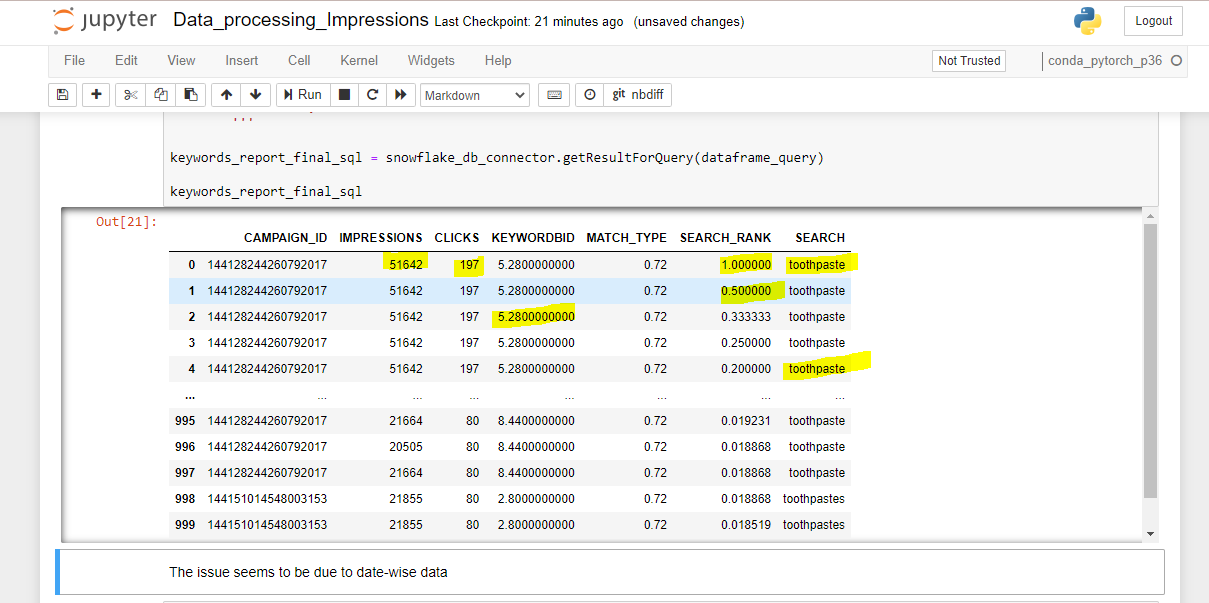

In [19]:
# USED THIS FOR checking date-between functionality it worked fine
dataframe_query_x = f'''
    select distinct SEARCH,FEED_DATE,SEARCH_RANK,SCRAPE_DATE,FEED_DATE
        from aramus.search_data_archive
        limit 1000;
        '''

# keywords_report_final_sql = snowflake_db_connector.getResultForQuery(dataframe_query)

# keywords_report_final_sql

In [20]:
keywords_report_final_copy=keywords_report_final_sql.copy(deep='true')

In [21]:
keywords_report_final_sql=keywords_report_final_sql.drop(['CAMPAIGN_ID','CLICKS','SEARCH'], axis = 1)

In [69]:
keywords_report_final_sql

,IMPRESSIONS,KEYWORDBID,MATCH_TYPE,SEARCH_RANK
0,44,6.5000000000,0.87,1.000000
1,44,6.5000000000,0.87,0.500000
2,44,6.5000000000,0.87,0.333333
3,44,6.5000000000,0.87,0.250000
4,44,6.5000000000,0.87,0.200000
...,...,...,...,...
2875,172,5.0000000000,0.87,0.020833
2876,22,5.0000000000,0.87,0.020833
2877,9,5.0000000000,0.87,0.020833
2878,14,6.5000000000,0.87,0.020833


In [56]:
keywords_report_final_sql

,IMPRESSIONS,KEYWORDBID,MATCH_TYPE,SEARCH_RANK
0,397,5.0000000000,0.87,1.000000
1,15,6.5000000000,0.87,1.000000
2,9,6.5000000000,0.87,1.000000
3,9,6.5000000000,0.87,0.500000
4,397,5.0000000000,0.87,0.500000
...,...,...,...,...
2203,589,6.5000000000,0.87,0.020833
2204,6,5.0000000000,0.87,0.020833
2205,5,5.0000000000,0.87,0.020833
2206,402,5.0000000000,0.87,0.020833


In [25]:
def func(x):
    if x < 16559:
        return "D"
    elif x < 23640:
        return "C"
    elif x < 30566:
        return "B"
    else:
        return 'A'

In [26]:
keywords_report_final_sql['Class'] = keywords_report_final_sql['IMPRESSIONS'].apply(func)

In [24]:
keywords_report_final_sql.describe()

,IMPRESSIONS
count,5000.000000
mean,28387.637800
std,21417.410449
min,2821.000000
25%,16559.000000
50%,23640.000000
75%,30566.000000
max,158091.000000


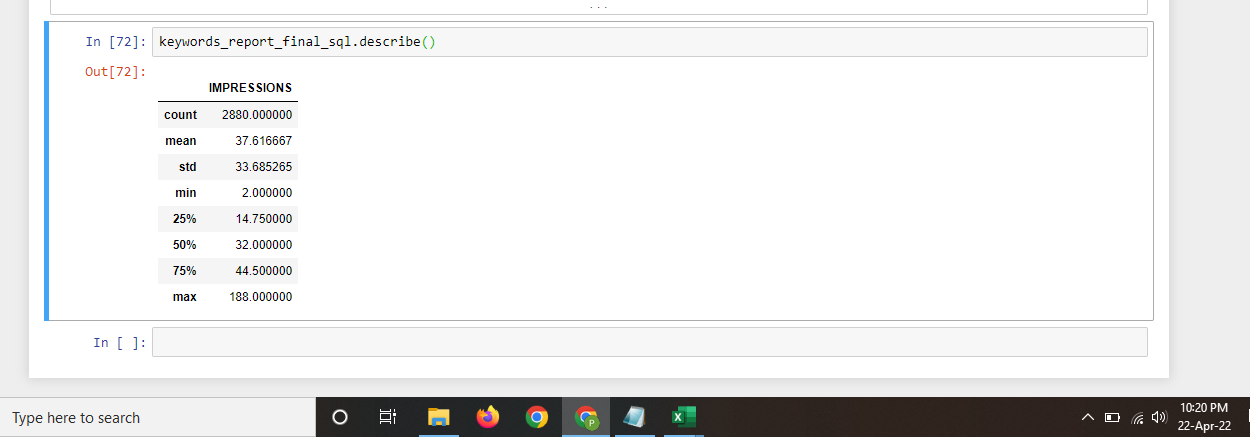

In [27]:
keywords_report_final_sql

,IMPRESSIONS,KEYWORDBID,MATCH_TYPE,SEARCH_RANK,Class
0,92073,10.3500000000,0.87,1.000000,A
1,92073,10.3500000000,0.87,0.500000,A
2,92073,10.3500000000,0.87,0.333333,A
3,92073,10.3500000000,0.87,0.250000,A
4,92073,10.3500000000,0.87,0.200000,A
...,...,...,...,...,...
4995,20851,15.0000000000,0.87,0.100000,C
4996,32194,2.2500000000,0.72,0.090909,A
4997,20851,15.0000000000,0.87,0.090909,C
4998,32194,2.2500000000,0.72,0.083333,A


In [28]:
print((keywords_report_final_sql == 0).sum(axis=0))
print(keywords_report_final_sql.isnull().sum().sum())

IMPRESSIONS    0
KEYWORDBID     0
MATCH_TYPE     0
SEARCH_RANK    0
Class          0
dtype: int64
0


**DTREE on Available Data**

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

X = keywords_report_final_sql[keywords_report_final_sql.columns[1:-1]]
y = keywords_report_final_sql['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=30)

In [30]:
# keywords_report_final_sql.columns[1:-1]

Index(['KEYWORDBID', 'MATCH_TYPE', 'SEARCH_RANK'], dtype='object')

In [36]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4000, 3) (1000, 3) (4000,) (1000,)


In [37]:
dtree=DecisionTreeClassifier(criterion='entropy',random_state=30)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=30)

In [38]:
predictions=dtree.predict(X_test)

In [39]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


print(classification_report(y_test,predictions))
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions))
print('Accuracy')
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           A       1.00      0.77      0.87       242
           B       0.47      0.54      0.50       259
           C       0.35      0.50      0.41       250
           D       0.57      0.39      0.46       249

    accuracy                           0.55      1000
   macro avg       0.60      0.55      0.56      1000
weighted avg       0.60      0.55      0.56      1000

Confusion Matrix
[[187  32  21   2]
 [  0 139  98  22]
 [  0  78 124  48]
 [  0  45 108  96]]
Accuracy
0.546


_With entropy criteriaa_

In [40]:
from sklearn import tree
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(16,16),dpi=1024)
tree.plot_tree(dtree)
plt.show()

KeyboardInterrupt: 

In [1]:
fig = plt.figure(figsize=(400,400))
tree.plot_tree(dtree)
# fig.savefig("decistion_tree.png")

#memory ran out error

NameError: name 'plt' is not defined

In [42]:
dtree_GINI=DecisionTreeClassifier(criterion='gini',random_state=30)
dtree_GINI.fit(X_train,y_train)
predictions_g=dtree_GINI.predict(X_test)

print(classification_report(y_test,predictions_g))
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions_g))
print('Accuracy')
print(accuracy_score(y_test,predictions_g))

              precision    recall  f1-score   support

           A       1.00      0.77      0.87       242
           B       0.47      0.54      0.50       259
           C       0.35      0.50      0.41       250
           D       0.57      0.39      0.46       249

    accuracy                           0.55      1000
   macro avg       0.60      0.55      0.56      1000
weighted avg       0.60      0.55      0.56      1000

Confusion Matrix
[[187  32  21   2]
 [  0 139  98  22]
 [  0  78 124  48]
 [  0  45 108  96]]
Accuracy
0.546


CAN USE ENTROPY FEATURE IMPORTANCE METRICS TO CHOOSE IMP FEATURES TO BE USED IN DTREE


import heapq 

feature_imp=dtree_Entropy.feature_importances_ 

print(feature_imp) 

print(len(feature_imp)) 

_**RANDOM FOREST**_

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
classifier_rf = RandomForestClassifier(random_state=30, n_jobs=-1, max_depth=10,
                                       n_estimators=100, oob_score=True)

In [48]:
%%time
classifier_rf.fit(X_train, y_train)

CPU times: user 461 ms, sys: 25.5 ms, total: 486 ms
Wall time: 441 ms


RandomForestClassifier(max_depth=10, n_jobs=-1, oob_score=True, random_state=30)

In [49]:
# checking the oob score
classifier_rf.oob_score_

0.57425

In [54]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [5,10,15],
    'min_samples_leaf': [5,10,20],
    'n_estimators': [50,100,150]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [55]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
CPU times: user 4.84 s, sys: 125 ms, total: 4.97 s
Wall time: 41.8 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [56]:
print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
print(rf_best)

0.57675
RandomForestClassifier(max_depth=5, min_samples_leaf=20, n_jobs=-1,
                       random_state=42)


In [57]:
rf_best.estimators_

[DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=787846414),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=996406378),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=1201263687),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                        random_state=423734972),
 DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=20,
                     

In [59]:
from sklearn.tree import plot_tree
plt.figure(figsize=(200,100))
plot_tree(rf_best.estimators_[5], feature_names = X_train.columns,class_names=['A','B','C','D'],filled=True);

In [2]:
plt.savefig('RF_impressions.png')

NameError: name 'plt' is not defined

_**MULTI-PERCEPTRON NN**_

In [62]:
# LET us do scaling on feature this time.
# for taking care of mean-feq centralization, normalized distribution of data
# using Scikit's inbuilt transformer

In [64]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# data[['company_name_encoded', 'location', 'minimum_exp', 'maximum_exp']] = sc.fit_transform(data[['company_name_encoded', 'location', 'minimum_exp', 'maximum_exp']])

In [72]:
X[['KEYWORDBID','MATCH_TYPE','SEARCH_RANK']]=sc.fit_transform(X[['KEYWORDBID','MATCH_TYPE','SEARCH_RANK']])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=30)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4000, 3) (1000, 3) (4000,) (1000,)


In [77]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

In [74]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)

In [78]:
classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=1)

In [94]:
from sklearn.metrics import confusion_matrix

y_pred_nn = classifier.predict(X_test)
confusion = confusion_matrix(y_pred, y_test)

In [112]:
impression_class=[y.unique()]
impression_class

[array(['A', 'C', 'B', 'D'], dtype=object)]

<AxesSubplot:>

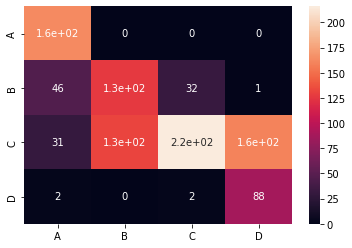

In [114]:
import seaborn as sns
cm
# sns is seaborn --already imported for tree visualization
sns.heatmap(confusion,xticklabels=['A','B','C','D'], yticklabels=['A','B','C','D'], annot=True)

In [98]:
print("Accuracy of MLPClassifier")
accuracy(cm)

print(classification_report(y_test,y_pred_nn))
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred_nn))
print('Accuracy')
print(accuracy_score(y_test,y_pred_nn))

Accuracy of MLPClassifier
              precision    recall  f1-score   support

           A       1.00      0.67      0.80       242
           B       0.62      0.49      0.55       259
           C       0.40      0.86      0.55       250
           D       0.96      0.35      0.52       249

    accuracy                           0.59      1000
   macro avg       0.74      0.60      0.60      1000
weighted avg       0.74      0.59      0.60      1000

Confusion Matrix
[[163  46  31   2]
 [  0 127 132   0]
 [  0  32 216   2]
 [  0   1 160  88]]
Accuracy
0.594


In [99]:
classifier_sgd_invscal = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='sgd',learning_rate='invscaling',random_state=1)

In [102]:
classifier_sgd_invscal.fit(X_train, y_train)
y_pred_sgd = classifier_sgd_invscal.predict(X_test)


In [103]:
print(classification_report(y_test,y_pred_sgd))
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred_sgd))
print('Accuracy')
print(accuracy_score(y_test,y_pred_sgd))

Accuracy of MLPClassifier
              precision    recall  f1-score   support

           A       1.00      0.30      0.46       242
           B       0.17      0.16      0.16       259
           C       0.13      0.10      0.11       250
           D       0.29      0.59      0.39       249

    accuracy                           0.28      1000
   macro avg       0.40      0.29      0.28      1000
weighted avg       0.39      0.28      0.28      1000

Confusion Matrix
[[ 72  69  49  52]
 [  0  41  99 119]
 [  0  37  24 189]
 [  0  93   8 148]]
Accuracy
0.285
